In [1]:
import json

with open("./All_score.json", "r", encoding="utf-8") as f:
    data = json.load(f)
    
print(data[0].keys())

dict_keys(['openai/gpt-4o', 'anthropic/claude-3.5-sonnet', 'deepseek/deepseek-chat', 'qwen/qwen-2.5-72b-instruct', 'x-ai/grok-beta'])


In [2]:
outline_scores = {}
model_names = data[0].keys()
for model_name in model_names:
    outline_scores[model_name] = []
    for d in data:
        outline_scores[model_name].append(d[model_name][0])

print(outline_scores)        

{'openai/gpt-4o': [[75.0, 70.0, 80.0, 75.0, 80.0, 85.0, 80.0, 75.0, 80.0, 85.0, 80.0, 85.0, 75.0, 80.0, 80.0], [75.0, 70.0, 80.0, 65.0, 75.0, 85.0, 80.0, 70.0, 80.0, 85.0, 75.0, 80.0, 75.0, 85.0, 80.0], [85.0, 75.0, 85.0, 80.0, 85.0, 90.0, 85.0, 80.0, 90.0, 85.0, 85.0, 90.0, 85.0, 90.0, 85.0], [85.0, 70.0, 85.0, 70.0, 80.0, 90.0, 85.0, 85.0, 80.0, 85.0, 80.0, 90.0, 85.0, 90.0, 80.0], [75.0, 65.0, 80.0, 60.0, 85.0, 90.0, 80.0, 85.0, 80.0, 75.0, 85.0, 90.0, 70.0, 90.0, 85.0], [80.0, 75.0, 70.0, 65.0, 80.0, 85.0, 85.0, 80.0, 70.0, 75.0, 80.0, 75.0, 70.0, 85.0, 80.0], [85.0, 70.0, 75.0, 65.0, 80.0, 85.0, 80.0, 75.0, 70.0, 85.0, 75.0, 85.0, 80.0, 80.0, 75.0], [80.0, 75.0, 85.0, 70.0, 80.0, 85.0, 80.0, 75.0, 80.0, 80.0, 75.0, 80.0, 80.0, 85.0, 80.0], [85.0, 70.0, 75.0, 65.0, 70.0, 80.0, 85.0, 70.0, 75.0, 80.0, 75.0, 85.0, 80.0, 75.0, 70.0], [80.0, 70.0, 85.0, 75.0, 80.0, 85.0, 80.0, 85.0, 75.0, 80.0, 75.0, 85.0, 80.0, 85.0, 75.0]], 'anthropic/claude-3.5-sonnet': [[85.0, 70.0, 80.0, 65.0, 75.

In [3]:
# assume same mean and variance for each model and each dimension
model_mean = {}
model_variance = {}
import numpy as np
# for model_name in model_names:
#     model_mean[model_name] = np.mean(outline_scores[model_name])
#     model_variance[model_name] = np.std(outline_scores[model_name])
for model_name in model_names:
    model_mean[model_name] = np.mean(np.array(outline_scores[model_name]))
    model_variance[model_name] = np.std(np.array(outline_scores[model_name]), axis=1)
    model_variance[model_name] = np.mean(model_variance[model_name])

# if any variance is 0, set it to 1
for model_name in model_names:
    if model_variance[model_name] == 0:
        model_variance[model_name] = 1

In [4]:
# convert to z-score
model_z_scores = {}
for model_name in model_names:
    #model_z_scores[model_name] = [(score - model_mean[model_name]) / model_variance[model_name] for score in outline_scores[model_name]]
    model_z_scores[model_name] = np.array(outline_scores[model_name])
    model_z_scores[model_name] = (model_z_scores[model_name] - model_mean[model_name]) / model_variance[model_name]
    print(model_variance[model_name])
    print(model_z_scores[model_name].shape)

5.564259025625958
(10, 15)
6.8565748196618115
(10, 15)
4.261566418155152
(10, 15)
3.492338263189712
(10, 15)
5.7453835978444285
(10, 15)


In [5]:
# scores in 2d array
scores = []
for i in range(10):
    for model_name in model_names:
        scores.append(model_z_scores[model_name][i])

scores = np.array(scores)
print(scores.shape)


(50, 15)


(50, 2)


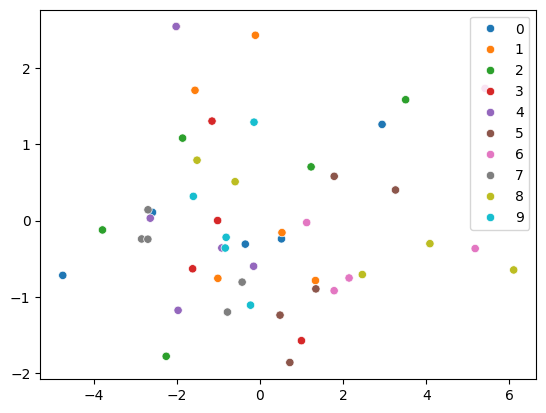

In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# PCA
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(scores.reshape(-1, 15))
print(pca_scores.shape)
pca_scores_df = pd.DataFrame(pca_scores, columns=["PC1", "PC2"])
outline_idx_repeated = []
for i in range(10):
    outline_idx_repeated.extend([i] * len(model_names))
pca_scores_df["outline_idx"] = outline_idx_repeated
plt.figure()
sns.scatterplot(x=pca_scores[:, 0], y=pca_scores[:, 1], hue=outline_idx_repeated, palette="tab10")
plt.show()

In [7]:
# check that each outline has similar vectors
# result should be shape = (10, 5, 5)
# using cosine similarity
from math import cos
import numpy as np

cosine_similarities = np.zeros((10, 5, 5))
scores_3d = scores.reshape(10, 5, 15)

for i in range(10):
    for j in range(5):
        for k in range(5):
            cosine_similarities[i, j, k] = np.dot(scores_3d[i, j], scores_3d[i, k]) / (np.linalg.norm(scores_3d[i, j]) * np.linalg.norm(scores_3d[i, k]))
      
print(cosine_similarities.mean(axis=0))
print((cosine_similarities.sum() - 10 * 5) / (10 * 5 * 5 - 10 * 5))

flat_value = set(cosine_similarities.flatten())
flat_value_1 = {v for v in flat_value if not (0.99 < v < 1.01)}

std_dev = np.std(list(flat_value_1))
se = std_dev / np.sqrt(len(cosine_similarities))

print(se)


[[1.         0.62710775 0.4041544  0.50549084 0.52572231]
 [0.62710775 1.         0.46896859 0.51587747 0.49319823]
 [0.4041544  0.46896859 1.         0.6050108  0.5537696 ]
 [0.50549084 0.51587747 0.6050108  1.         0.37861341]
 [0.52572231 0.49319823 0.5537696  0.37861341 1.        ]]
0.5077913399877539
0.07852835525029332


In [8]:
# between group similarity
# result should be shape = (10, 10, 5, 5)
# using cosine similarity

cosine_similarities = np.zeros((10, 10, 5, 5))
for i in range(10):
    for j in range(10):
        if i == j:
            continue
        for k in range(5):
            for l in range(5):
                cosine_similarities[i, j, k, l] = np.dot(scores_3d[i, k], scores_3d[j, l]) / (np.linalg.norm(scores_3d[i, k]) * np.linalg.norm(scores_3d[j, l]))
                
print(np.mean(cosine_similarities))

flat_value = set(cosine_similarities.flatten())
flat_value_2 = {v for v in flat_value if not (0.99 < v < 1.01)}

std_dev = np.std(list(flat_value_2))
se = std_dev / np.sqrt(len(cosine_similarities))

print(se)

0.4010604985436129
0.08086413383881551


TtestResult(statistic=2.4700900974123434, pvalue=0.013621499079017878, df=1460.0)


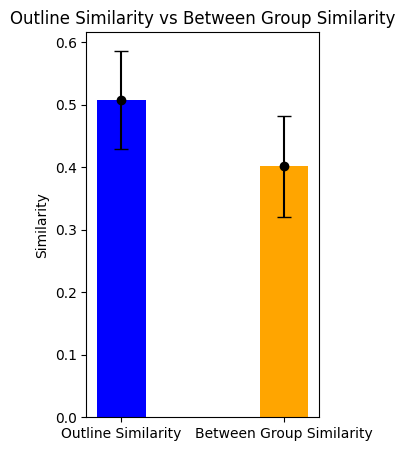

In [10]:
import matplotlib.pyplot as plt

#p-values
from scipy.stats import ttest_ind
print(ttest_ind(list(flat_value_1), list(flat_value_2)))


# Calculate the mean similarities
outline_similarity = 0.5077913399877539
between_group_similarity = 0.4010604985436129

# Create a bar chart
labels = ['Outline Similarity', 'Between Group Similarity']
values = [outline_similarity, between_group_similarity]
# Define the error values
errors = [0.07852835525029332, 0.08086413383881551]

# Add error bars to the bar chart
plt.figure(figsize=(3, 5))
plt.errorbar(labels, values, yerr=errors, fmt='o', color='black', capsize=5)
plt.bar(labels, values, width = 0.3, color=['blue', 'orange'])
plt.ylabel('Similarity')
plt.title('Outline Similarity vs Between Group Similarity')
plt.show()